# Translating Constraints into QUBOs for the  Quadratic Knapsack Problem
```python

In [253]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer.primitives import Estimator as AerEstimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

# QKP problem parameters

In [254]:
# n_items = 7
# weights = [37, 10, 24, 27, 11, 19, 35]
# profits = np.array([[44, 64, 64, 70, 47, 47, 0],
#                     [64, 47, 0, 0, 0, 41, 54],
#                     [64, 0, 1, 11, 12, 8, 15],
#                     [70, 0, 11, 0, 6, 2, 28],
#                     [47, 0, 12, 6, 21, 0, 0],
#                     [47, 41, 8, 2, 0, 46, 15],
#                     [0, 54, 15, 28, 0, 15, 39]])
# capacity = 85

# total_possible_profit = np.sum(profits) 
# print(f"Total possible profit: {total_possible_profit / 4}")
# penalty_factor = total_possible_profit / 4

# # penalty_factor = total_possible_profit / (total_possible_weight-capacity)**2
# # print(f"Penalty factor: {penalty_factor}")

In [255]:
n_items = 7
weights = [25, 5, 22, 16, 1, 26, 34]

profits = np.array([[45, 0, 61, 0, 0, 58, 0],
                      [0, 45, 28, 64, 68, 0, 0],
                      [61, 28, 37, 55, 32, 14, 30],
                      [0, 64, 55, 24, 4, 52, 30],
                      [0, 68, 32, 4, 39, 25, 0],
                      [58, 0, 14, 52, 25, 4, 0],
                      [0, 0, 30, 30, 0, 0, 19]])
capacity = 95

total_possible_profit = np.sum(profits) 
print(f"Total possible profit: {total_possible_profit / 4}")
penalty_factor = total_possible_profit / 4

# penalty_factor = total_possible_profit / (total_possible_weight-capacity)**2
# print(f"Penalty factor: {penalty_factor}")

Total possible profit: 313.75


In [256]:
# n_items = 4
# weights = [1, 1, 1, 1]
# profits = np.array([[1, 1, 5, 1],
#                     [1, 7, 3, 0],
#                     [5, 3, 7, 4],
#                     [1, 0, 4, 1]]
#                     )
# capacity = 3

# total_possible_profit = np.sum(profits) 
# print(f"Total possible profit: {total_possible_profit / 4}")
# penalty_factor = total_possible_profit / 4

# PROBLEM CONSTRUCTION AS QUBO


In [257]:
# from collections import defaultdict
# from collections import defaultdict
# from docplex.mp.model import Model
# from qiskit_optimization.translators import from_docplex_mp
# from qiskit_optimization.converters import QuadraticProgramToQubo

# def build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor):
#     """
#     Build the Hamiltonian qubo to the QKP with quadratic penalty and Slack variables.
#     Returns a sparsepauliop to use in qaoa.
#     """
#     # Determinar cantidad de slack variables necesarias
#     slack_bits = int(np.ceil(np.log2(capacity + 1)))
#     slack_weights = [2**k for k in range(slack_bits)]

#     mdl = Model()
#     x = mdl.binary_var_list(n_items, name="x")
#     y = mdl.binary_var_list(slack_bits, name="y")

#     # Termino objetivo cuadrático
#     obj = mdl.sum(profits[i][j] * x[i] * x[j] for i in range(n_items) for j in range(n_items))

#     # Penalidad
#     lhs = mdl.sum(weights[j]*x[j] for j in range(n_items)) + mdl.sum(slack_weights[k]*y[k] for k in range(slack_bits))
#     penalty = penalty_factor * (capacity - lhs)**2

#     mdl.minimize(-obj + penalty)

#     # Convertir a QUBO
#     qp = from_docplex_mp(mdl)
#     qubo = QuadraticProgramToQubo().convert(qp)

#     # Obtener matrices cuadráticas y lineales
#     Q = qubo.objective.quadratic.to_array()
#     c = qubo.objective.linear.to_array()
#     num_vars = qubo.get_num_binary_vars()

#     pauli_dict = defaultdict(float)

#     # Términos cuadráticos
#     for i in range(num_vars):
#         for j in range(i, num_vars):
#             coeff = Q[i, j] if i != j else Q[i, i]/2
#             if np.abs(coeff) > 1e-8:
#                 pauli_i = ["I"] * num_vars
#                 pauli_i[i] = "Z"
#                 if i == j:
#                     pauli_str = "".join(pauli_i)[::-1]
#                     pauli_dict[pauli_str] += coeff / 4
#                     pauli_dict["I" * num_vars] += coeff / 4
#                     pauli_dict[pauli_str] += -coeff / 2
#                 else:
#                     pauli_j = pauli_i.copy()
#                     pauli_j[j] = "Z"
#                     zz = pauli_j[::-1]
#                     pauli_dict["".join(zz)] += coeff / 4
#                     zi = "".join(pauli_i)[::-1]
#                     zj = ["I"] * num_vars; zj[j] = "Z"
#                     zj = "".join(zj)[::-1]
#                     pauli_dict[zi] += -coeff / 4
#                     pauli_dict[zj] += -coeff / 4
#                     pauli_dict["I" * num_vars] += coeff / 4

#     # Términos lineales
#     for i in range(num_vars):
#         coeff = c[i]
#         if np.abs(coeff) > 1e-8:
#             zi = ["I"] * num_vars
#             zi[i] = "Z"
#             zi = "".join(zi)[::-1]
#             pauli_dict[zi] += -coeff / 2
#             pauli_dict["I" * num_vars] += coeff / 2

#     return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

# cost_hamiltonian = build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor)
# print("Hamiltonian QUBO:", cost_hamiltonian)

In [258]:
from collections import defaultdict

def build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor):
    """
    Build the Hamiltonian qubo to the QKP with quadratic penalty and Slack variables.
    Returns a sparsepauliop to use in qaoa.
    """
    # Determinar cantidad de slack variables necesarias
    slack_bits = int(np.ceil(np.log2(capacity + 1)))
    slack_weights = [2**k for k in range(slack_bits)]
    
    num_vars = n_items + slack_bits

    pauli_dict = defaultdict(float)

    # Términos cuadráticos
    # x bits: 0 to n_items-1
    for i in range(n_items):
        for j in range(i, n_items):
            pauli_i = ["I"] * num_vars
            pauli_i[i] = "Z"
            coeff = 1/4 * (penalty_factor*weights[i]*weights[j] - profits[i][j])
            if i == j: 
                pauli_str = "".join(pauli_i)[::-1]
                pauli_dict[pauli_str] = coeff 
            else:
                pauli_j = pauli_i.copy()
                pauli_j[j] = "Z"
                pauli_str = "".join(pauli_j)[::-1]
                pauli_dict[pauli_str] += coeff * 2
        
        for j in range(n_items, num_vars):
            pauli_i = ["I"] * num_vars
            pauli_i[i] = "Z"
            pauli_i[j] = "Z"
            coeff = 1/2 * (penalty_factor*weights[i]*slack_weights[j - n_items])
            pauli_str = "".join(pauli_i)[::-1]
            pauli_dict[pauli_str] += coeff
            
    # y bits: n_items to num_vars-1
    for i in range(n_items, num_vars):
        for j in range(i, num_vars):
            pauli_i = ["I"] * num_vars
            pauli_i[i] = "Z"
            coeff = penalty_factor/4 * (slack_weights[i - n_items] * slack_weights[j - n_items])
            if i == j:
                pauli_dict[pauli_str] = coeff 
            else:
                pauli_j = pauli_i.copy()
                pauli_j[j] = "Z"
                pauli_str = "".join(pauli_j)[::-1]
                pauli_dict[pauli_str] += coeff * 2
        
        # for j in range(n_items):
        #     pauli_i = ["I"] * num_vars
        #     pauli_i[i] = "Z"
        #     pauli_i[j] = "Z"
        #     coeff = 1/2 * (penalty_factor * slack_weights[i - n_items] * weights[j])
        #     pauli_str = "".join(pauli_i)[::-1]
        #     pauli_dict[pauli_str] += coeff
    
    
    # Términos lineales
    # x bits: 0 to n_items-1
    for i in range(n_items):
        pauli_i = ["I"] * num_vars
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1] 
        coeff1 = 0
        coeff2 = 0
        for j in range(0, n_items):
            coeff1 += -1/2 * (penalty_factor*weights[i]*weights[j] - profits[i][j])
            
        for j in range(n_items, num_vars):
            coeff2 += 1/2 * weights[i]*slack_weights[j - n_items]
            
        pauli_dict[pauli_str] += coeff1 + penalty_factor*capacity*weights[i] - penalty_factor*coeff2
        
    # y bits: n_items to num_vars-1
    for i in range(n_items, num_vars):
        pauli_i = ["I"] * num_vars
        pauli_i[i] = "Z"
        pauli_str = "".join(pauli_i)[::-1] 
        for j in range(n_items, num_vars):
            coeff1 += -1/2 * (slack_weights[i - n_items] * slack_weights[j - n_items])
            
        for j in range(n_items):
            coeff2 += 1/2 * slack_weights[i - n_items] * weights[j]

        pauli_dict[pauli_str] += penalty_factor * (capacity*slack_weights[i - n_items] - coeff1) - penalty_factor * coeff2


    return SparsePauliOp.from_list([(p, coeff) for p, coeff in pauli_dict.items() if abs(coeff) > 1e-8])

cost_hamiltonian = build_qkp_cost_hamiltonian(n_items, weights, profits, capacity, penalty_factor)
print("Hamiltonian QUBO:", cost_hamiltonian)


Hamiltonian QUBO: SparsePauliOp(['IIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZZ', 'IIIIIIIIIIIZIZ', 'IIIIIIIIIIZIIZ', 'IIIIIIIIIZIIIZ', 'IIIIIIIIZIIIIZ', 'IIIIIIIZIIIIIZ', 'IIIIIIZIIIIIIZ', 'IIIIIZIIIIIIIZ', 'IIIIZIIIIIIIIZ', 'IIIZIIIIIIIIIZ', 'IIZIIIIIIIIIIZ', 'IZIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZI', 'IIIIIIIIIIIZZI', 'IIIIIIIIIIZIZI', 'IIIIIIIIIZIIZI', 'IIIIIIIIZIIIZI', 'IIIIIIIZIIIIZI', 'IIIIIIZIIIIIZI', 'IIIIIZIIIIIIZI', 'IIIIZIIIIIIIZI', 'IIIZIIIIIIIIZI', 'IIZIIIIIIIIIZI', 'IZIIIIIIIIIIZI', 'ZIIIIIIIIIIIZI', 'IIIIIIIIIIIZII', 'IIIIIIIIIIZZII', 'IIIIIIIIIZIZII', 'IIIIIIIIZIIZII', 'IIIIIIIZIIIZII', 'IIIIIIZIIIIZII', 'IIIIIZIIIIIZII', 'IIIIZIIIIIIZII', 'IIIZIIIIIIIZII', 'IIZIIIIIIIIZII', 'IZIIIIIIIIIZII', 'ZIIIIIIIIIIZII', 'IIIIIIIIIIZIII', 'IIIIIIIIIZZIII', 'IIIIIIIIZIZIII', 'IIIIIIIZIIZIII', 'IIIIIIZIIIZIII', 'IIIIIZIIIIZIII', 'IIIIZIIIIIZIII', 'IIIZIIIIIIZIII', 'IIZIIIIIIIZIII', 'IZIIIIIIIIZIII', 'ZIIIIIIIIIZIII', 'IIIIIIIIIZIIII', 'IIIIIIIIZZIIII', 'IIIIIIIZIZIIII', 'IIIIIIZIIZII

# QAOA configuration

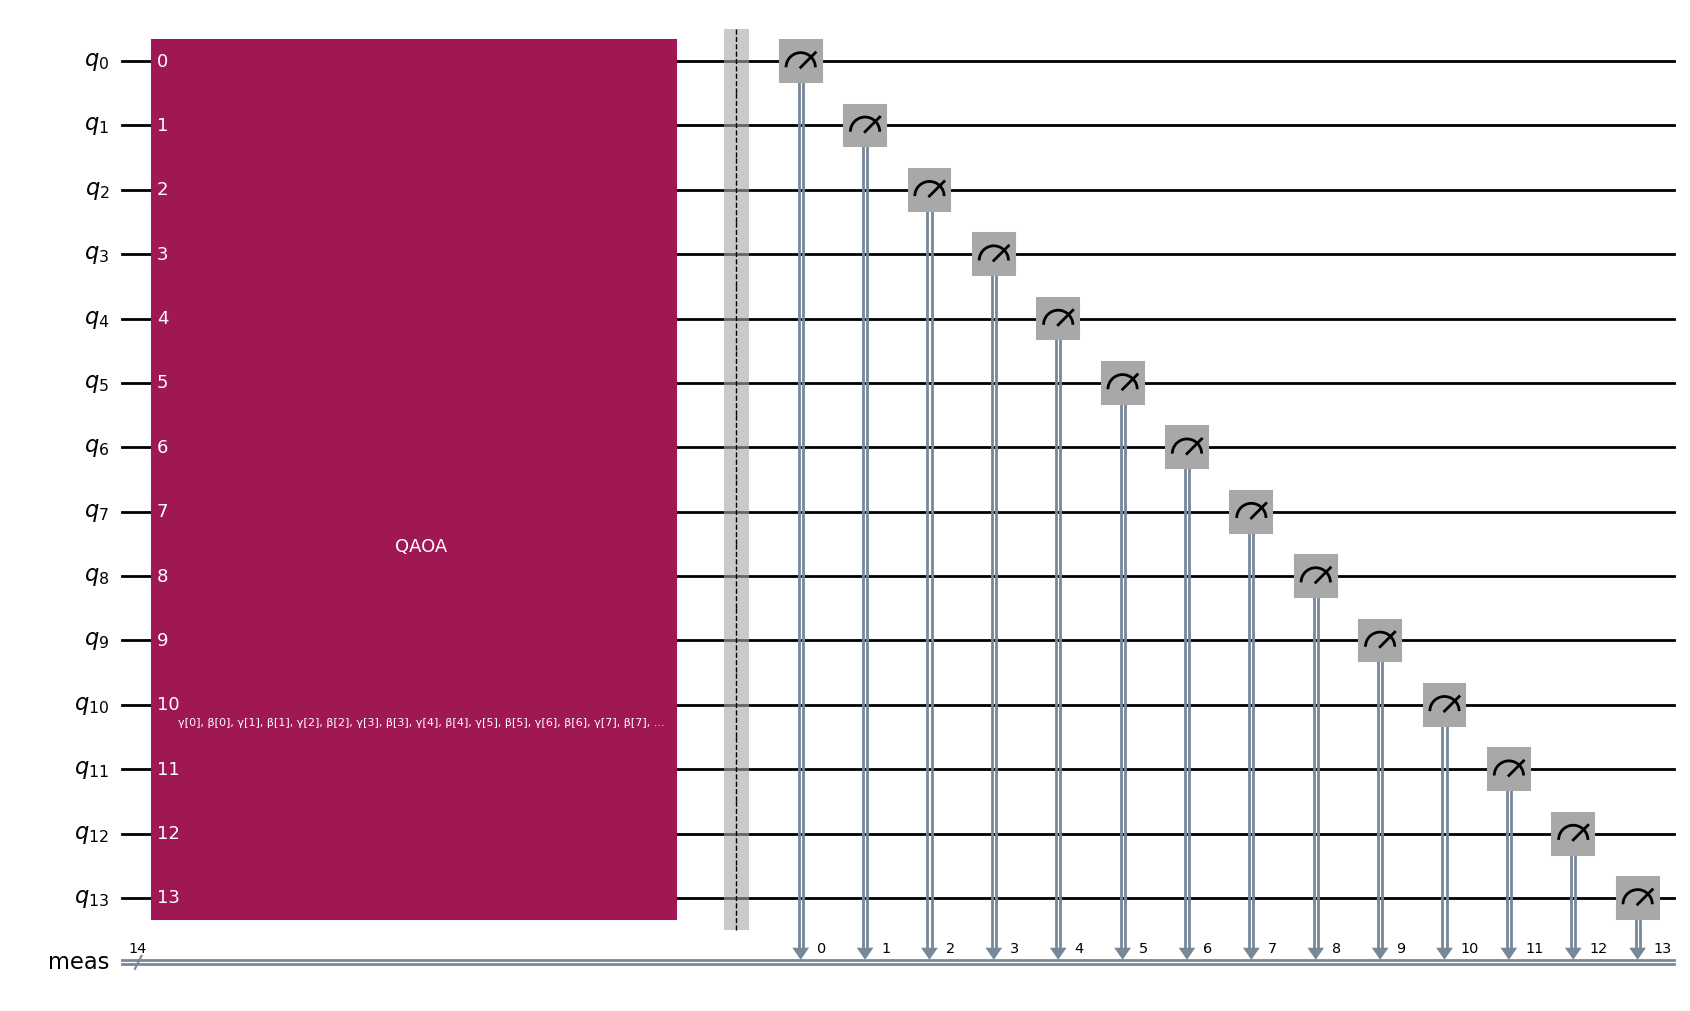

In [259]:
from qiskit.circuit.library import QAOAAnsatz
reps = 10
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

circuit.draw('mpl')

In [260]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta] * reps
print("Parameters:", circuit.parameters)
print("Initial params:", init_params)    

Parameters: ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(β[4]), ParameterVectorElement(β[5]), ParameterVectorElement(β[6]), ParameterVectorElement(β[7]), ParameterVectorElement(β[8]), ParameterVectorElement(β[9]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3]), ParameterVectorElement(γ[4]), ParameterVectorElement(γ[5]), ParameterVectorElement(γ[6]), ParameterVectorElement(γ[7]), ParameterVectorElement(γ[8]), ParameterVectorElement(γ[9])])
Initial params: [3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.14

# Solve the problem

In [261]:
objective_func_vals = []

estimator = AerEstimator()
estimator.set_options(shots=1000)

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    circuit_bound = ansatz.assign_parameters(params)
    job = estimator.run([circuit_bound], [hamiltonian])
    result = job.result()
    cost = result.values[0]
    objective_func_vals.append(cost)
    return cost

result = minimize(
    cost_func_estimator,
    init_params,
    args=(circuit, cost_hamiltonian, estimator),
    method="COBYLA", 
    tol=1e-10,
    options={'maxiter': 5000}
)

print("Optimization Result:\n", result)

Optimization Result:
  message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -633475451.146125
       x: [ 4.142e+00  1.571e+00 ...  3.145e+00  1.571e+00]
    nfev: 361
   maxcv: 0.0


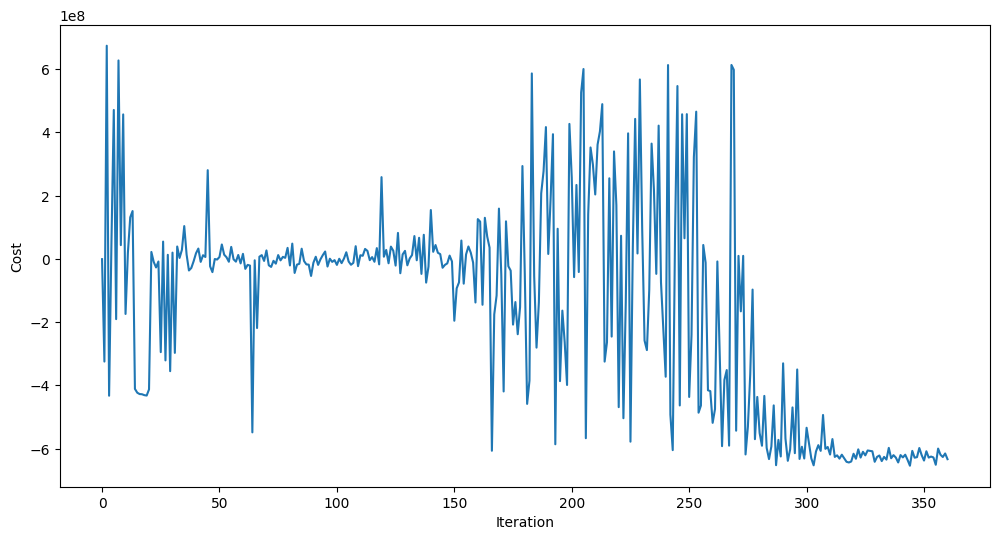

In [262]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [263]:
# estimator = AerEstimator()
# estimator.set_options(shots=1000)

# # Crear grilla de valores
# beta_vals = np.linspace(0, np.pi, 50)
# gamma_vals = np.linspace(0, 2*np.pi, 50)
# Z = np.zeros((len(beta_vals), len(gamma_vals)))

# # Evaluar valor esperado en la grilla
# for i, beta in enumerate(beta_vals):
#     for j, gamma in enumerate(gamma_vals):
#         param_dict = dict(zip(circuit.parameters, [beta, gamma]*reps))
#         bound_circuit = circuit.assign_parameters(param_dict)
#         job = estimator.run([bound_circuit], [cost_hamiltonian])
#         result2 = job.result()
#         Z[i, j] = result2.values[0]


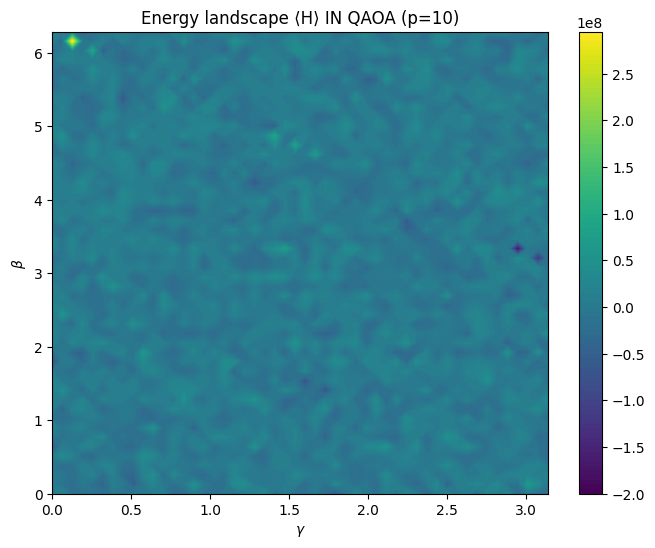

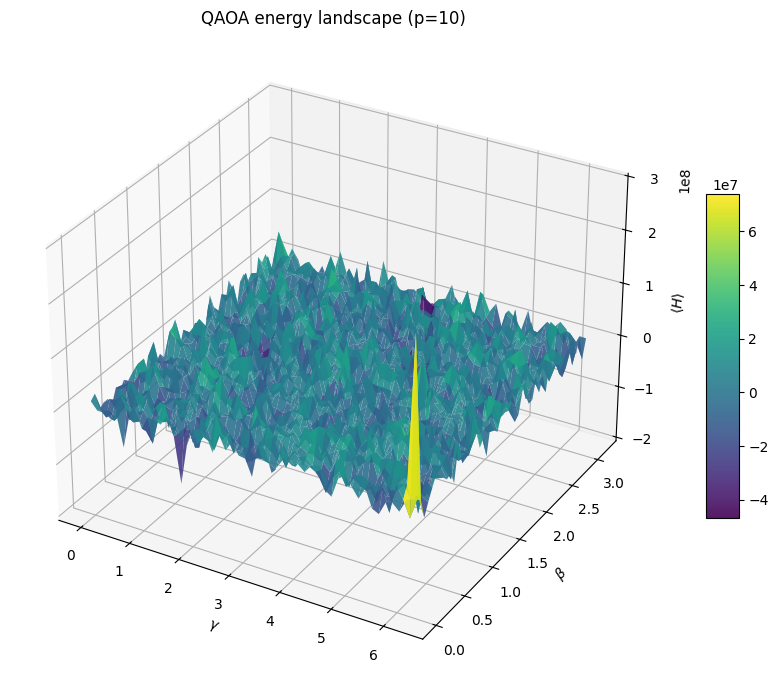

In [264]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Graph the energy landscape
B, Gm = np.meshgrid(gamma_vals, beta_vals)
plt.figure(figsize=(8,6))
cp = plt.contourf(Gm, B, Z, levels=100, cmap='viridis')
plt.colorbar(cp)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.title('Energy landscape ⟨H⟩ IN QAOA (p={})'.format(reps))
plt.show()

# Create parameter mesh for the X axis (gamma) and y (beta)
BETA, GAMMA = np.meshgrid(beta_vals, gamma_vals, indexing='ij')

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface
surf = ax.plot_surface(
    GAMMA, BETA, Z, 
    cmap='viridis', 
    edgecolor='none', 
    alpha=0.9
)

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle H \rangle$')
ax.set_title('QAOA energy landscape (p={})'.format(reps))
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.tight_layout()
plt.show()


In [265]:
optimized_circuit = circuit.assign_parameters(result.x)
# optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [266]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram


# Transpilar para el simulador
simulator = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(optimized_circuit, simulator)

# Ejecutar el circuito
shots = 10_000
job = simulator.run(transpiled_circuit, backend=simulator, shots=shots)
result = job.result()

# Obtener conteos
counts = result.get_counts()

# Normalizar los resultados
final_distribution = {key: val/shots for key, val in counts.items()}



In [267]:
keys = list(final_distribution.keys())
values = list(final_distribution.values())
most_likely = keys[np.argmax(np.abs(values))]

result_bitstring = [int(digit) for digit in most_likely]
print("Result bitstring as list:", result_bitstring)

Result bitstring as list: [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]


In [268]:
def evaluate_solution(bitstring, n_items, weights, profits, capacity):
    if len(bitstring) != n_items:
        bitstring = bitstring[:n_items]

    total_weight = sum(weights[i] for i in range(len(bitstring)) if bitstring[i] == 1)
    total_profit = sum(profits[i][j] * bitstring[i] * bitstring[j] for i in range(len(bitstring)) for j in range(len(bitstring)))
    
    return total_profit, total_weight <= capacity

total_profit, is_valid = evaluate_solution(result_bitstring, n_items, weights, profits, capacity)
print("Total Profit:", total_profit, "\nValid Solution:", is_valid)

real_solution = [1, 1, 1, 1, 1, 1, 0]
total_profit, is_valid = evaluate_solution(real_solution, n_items, weights, profits, capacity)
print("Total Profit:", total_profit, "\nValid Solution:", is_valid)


Total Profit: 972 
Valid Solution: False
Total Profit: 1116 
Valid Solution: True


# Classical solution

In [269]:
def solve_qkp(n_items, weights, profits, capacity, penalty_coeff=1000, max_iter=5000, tol=1e-6):
    weights = np.array(weights)
    profits = np.array(profits)

    # Función objetivo (negativa porque minimize hace minimización)
    def objective(x):
        x = np.clip(x, 0, 1)  # Asegura que esté en [0,1]
        benefit = np.dot(x, np.dot(profits, x))
        weight = np.dot(weights, x)
        penalty = penalty_coeff * max(0, weight - capacity)**2
        return -benefit + penalty  # Negativo porque estamos maximizando

    # Condición inicial: fracción uniforme
    x0 = np.random.rand(n_items)

    # Restricciones: variables entre 0 y 1 (relajación)
    bounds = [(0, 1) for _ in range(n_items)]

    res = minimize(objective, x0, method='COBYLA',
                   bounds=bounds,
                   options={'maxiter': max_iter, 'tol': tol})

    # Solución continua
    x_cont = res.x
    # Redondeo simple (se puede mejorar con técnicas como threshold adaptativo)
    x_bin = (x_cont > 0.5).astype(int)

    # Cálculo de métricas finales
    final_profit = np.dot(x_bin, np.dot(profits, x_bin))
    final_weight = np.dot(weights, x_bin)

    return {
        'x_continuous': x_cont,
        'x_binary': x_bin,
        'profit': final_profit,
        'weight': final_weight,
        'feasible': final_weight <= capacity,
        'success': res.success,
        'message': res.message
    }

In [270]:
# iteration = 300
# solution = np.zeros(n_items)
# profit = 0

# best_solutions = []
# unique_solutions = set()
# for i in range(iteration):
#     result = solve_qkp(n_items, weights, profits, capacity, penalty_coeff=penalty_factor, max_iter=50, tol=1e-6)
#     sol_tuple = tuple(result['x_binary'])
#     if result['feasible'] and sol_tuple not in unique_solutions:
#         unique_solutions.add(sol_tuple)
#         best_solutions.append((result['profit'], result['x_binary'].copy()))
#         best_solutions = sorted(best_solutions, key=lambda x: x[0], reverse=True)[:3]
#         if result['profit'] > profit:
#             solution = result['x_binary']
#             profit = result['profit']

In [271]:
print("Top 3 solutions:")
for idx, (p, sol) in enumerate(best_solutions, 1):
    print(f"{idx}: Profit={p}, Solution={sol}")

Top 3 solutions:
1: Profit=1116, Solution=[1 1 1 1 1 1 0]
2: Profit=819, Solution=[1 1 1 1 0 1 0]
3: Profit=814, Solution=[1 1 1 1 1 0 0]
